In [1]:
%%capture
%pip install numpy pandas matplotlib

In [2]:
import relationalai as rai
from relationalai.std.graphs import Graph
from relationalai.std import alias, aggregates

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

In [3]:
# create a database named TransferTokenDB
model = rai.Model("TransferTokenDB")

SRC_SCHEMA="TOKENTRANSFER.PUBLIC.DATA" #change this to your snowflake dataset
token_dataset = model.Type("Data", source=SRC_SCHEMA)

Let's count the total number of tuples in the data we read.

In [4]:
with model.query() as select:
    e = token_dataset()
    count_transfers = aggregates.count(e)
    response = select(alias(count_transfers, "# Transfers"))

print(response.results)

   # transfers
0        21602


In [6]:
# We create two entities to represent the senders/receivers, and the transfers respectively
Person = model.Type("Person")
Transfer = model.Type("TokenTransfer")

with model.rule():
    e = token_dataset()
    source = e.sender
    destination = e.receiver
    p1 = Person.add(person_id=source)
    p2 = Person.add(person_id=destination)
    Transfer.add(sender=p1, receiver=p2)


Let's see the total number of distinct sender/receivers.

In [7]:
with model.query() as select:
    p = Person()
    count_person = aggregates.count(p) # using p.person_id instead of p gives the same result
    response = select(alias(count_person, "# Persons"))

print(response.results)

   # persons
0       2764


We create a directed, unweighted graph from the transfers.

In [8]:
directed_graph = Graph(model, undirected = False, weighted=False)
directed_graph.Node.extend(Person)

with model.rule():
    t = Transfer()
    directed_graph.Edge.add(t.sender, t.receiver)

Let's check the number of nodes and edges.

In [9]:

with model.query() as select:
    num_nodes = directed_graph.compute.num_nodes()
    num_edges = directed_graph.compute.num_edges()
    stats = select(alias(num_nodes, "#nodes"), alias(num_edges, "#edges"))

print(stats.results)

   #nodes  #edges
0    2764    7847


We can compute the degree distributions and plot them as follows:

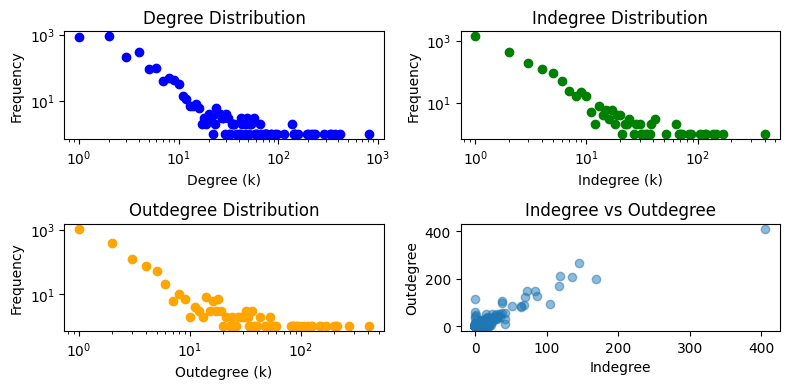

In [10]:
with model.query() as select:
    node = directed_graph.Node()
    degree = directed_graph.compute.degree(node)
    indegree = directed_graph.compute.indegree(node)
    outdegree = directed_graph.compute.outdegree(node)
    node.set(degree = degree)
    response = select(node,  alias(degree, "degree"), alias(indegree, "indegree"), alias(outdegree, "outdegree"))

directed_node_stats_df = response.results

# Filter to only non-zero for log-scale plots
nonzero_deg = directed_node_stats_df[directed_node_stats_df['degree'] > 0]
nonzero_indeg = directed_node_stats_df[directed_node_stats_df['indegree'] > 0]
nonzero_outdeg = directed_node_stats_df[directed_node_stats_df['outdegree'] > 0]

fig, axs = plt.subplots(2, 2, figsize=(8, 4))

# 1. Degree distribution
degree_counts = nonzero_deg['degree'].value_counts().sort_index()
axs[0, 0].scatter(degree_counts.index, degree_counts.values, color='blue')
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].set_title('Degree Distribution')
axs[0, 0].set_xlabel('Degree (k)')
axs[0, 0].set_ylabel('Frequency')

# 2. Indegree distribution
indegree_counts = nonzero_indeg['indegree'].value_counts().sort_index()
axs[0, 1].scatter(indegree_counts.index, indegree_counts.values, color='green')
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_title('Indegree Distribution')
axs[0, 1].set_xlabel('Indegree (k)')
axs[0, 1].set_ylabel('Frequency')

# 3. Outdegree distribution
outdegree_counts = nonzero_outdeg['outdegree'].value_counts().sort_index()
axs[1, 0].scatter(outdegree_counts.index, outdegree_counts.values, color='orange')
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_title('Outdegree Distribution')
axs[1, 0].set_xlabel('Outdegree (k)')
axs[1, 0].set_ylabel('Frequency')

# 4. Indegree vs Outdegree scatter with annotations
axs[1, 1].scatter(directed_node_stats_df['indegree'], directed_node_stats_df['outdegree'], alpha=0.5)

axs[1, 1].set_xlabel('Indegree')
axs[1, 1].set_ylabel('Outdegree')
axs[1, 1].set_title('Indegree vs Outdegree')

plt.tight_layout()
plt.show()


If the user wants to further filter nodes based on specific characteristics, this can be easily achieved by adding a logical condition. For example, to display only the nodes with degree 4, 5, or 6, one can use the following approach:

In [11]:
# we can choose a subset of the nodes based on the degree
with model.query() as select:
    node = directed_graph.Node()
    degree = directed_graph.compute.degree(node)
    degree >= 4
    degree < 7
    filtered_response = select(alias(Person(node).person_id, "node_id"),  alias(degree, "degree"))

filtered_df = filtered_response.results
filtered_df.head(12)

,node_id,degree
0,0x00c600b30fb0400701010f4b080409018b9006e0,5
1,0x010b6af33c8a6ef8d2c47d67ec2b213cbfb90c16,4
2,0x0176e73cf528c7b91b1500fcec380e67c17a5b71,5
3,0x01c37bd2a69c259efa96454889361cbf83937fcc,4
4,0x01d5bf76ddae666c720048cc88dde9fd030f4552,6
5,0x039f7c7e22c1c3bba5e871029ca72d5ddead295b,4
6,0x03d4e4a360f2886b5ab797cd3d61da331f77c710,4
7,0x03ec6374bee663c3dedb3de3df99750c6f51727c,5
8,0x0439008e5decb4c4d3099d6f050fb4aa774fec96,4
9,0x0596c3e687429ada8997a0b8f6ff98e1ddaf8ee1,4


We can identify the most central nodes using different centrality measures. For example, we can calculate the PageRank to determine node importance.

In [12]:
with model.rule():
    p = directed_graph.Node()
    pagerank = directed_graph.compute.pagerank(p)
    p.set(pagerank=pagerank)
    directed_graph.Node(p).set(pagerank = pagerank)

with model.query() as select:
    p = directed_graph.Node()
    rank = aggregates.rank_desc(p.pagerank)
    response = select(rank, alias(Person(p).person_id, "person_id"), p.pagerank)

print(response.results.head(10))


   result                                   person_id  pagerank
0       1  0x57f25dd735ed502e46fb63af820297bf8409c703  0.074719
1       2  0xd84f296d2c7b3247bed49e951f62b5d17c8d2c14  0.022954
2       3  0x6bf7d6753756805ae812deaad440bc5e21fd27bd  0.019802
3       4  0xbbd6ca30184c1eab3b75b978fcafb171b5c7543f  0.019374
4       5  0x2acac41fe2a44e41c5cf9639367a9310e5c76999  0.012903
5       6  0xd2e824a035d9fc5d6b9b6e55d60dea6a75ec3265  0.011784
6       7  0x2affd8f9cd2d0f67dc3746d87ccb4a76ca685619  0.011209
7       8  0xeac1a3a68693f34560758a4e9f3e697186a04108  0.009161
8       9  0x3a17df7c2bbcefed31c8b9d2d1742adacddc8dd2  0.008413
9      10  0xf96f86344308441fd6482057e16d2aa8c6b96585  0.007086


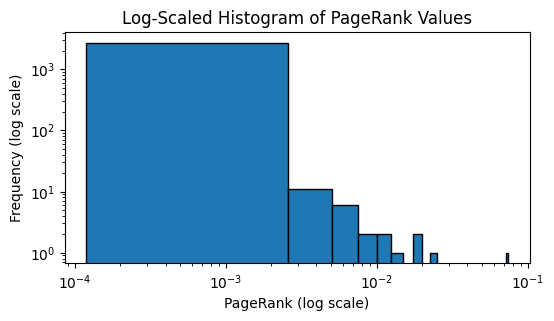

In [14]:
pagerank_df = response.results

# Avoid log(0) by filtering out zero or near-zero values
nonzero_pagerank = pagerank_df[pagerank_df['pagerank'] > 0]['pagerank']
plt.figure(figsize=(6, 3))
plt.hist(nonzero_pagerank, bins=30, edgecolor='black', log=True)
plt.xscale('log')
plt.title('Log-Scaled Histogram of PageRank Values')
plt.xlabel('PageRank (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()

As we see the node with id `0x57f25dd735ed502e46fb63af820297bf8409c703` is the most central according to Pagerank. Let's extract its one hop egonetwork. We begin by defining a function that constructs and returns a graphlib object from a given set of nodes and edges. This is particularly useful when we intend to apply further graph operations or analyses.

In [15]:
def create_graph(model, node_set, edge_list, undirected=False):
    graph = Graph(model, undirected=undirected)
    with model.rule(dynamic=True):
        node_dict = {}
        for id in node_set:
            node = graph.Node.add(id=id)
            node_dict[id] = node
        for u, v in edge_list:
            graph.Edge.add(node_dict[u], node_dict[v])
    return graph


In [16]:
with model.query() as select:
    node = directed_graph.Node()
    Person(node).person_id == '0x57f25dd735ed502e46fb63af820297bf8409c703'
    a,b = directed_graph.compute.ego_network(node, 1)
    ego_response = select(alias(Person(node).person_id,"ego_node id"), alias(Person(a).person_id, "u"), alias(Person(b).person_id, "v"))

# let's view the first 10 results of the ego network query
print(ego_response.results.head(10))



                                  ego_node id  \
0  0x57f25dd735ed502e46fb63af820297bf8409c703   
1  0x57f25dd735ed502e46fb63af820297bf8409c703   
2  0x57f25dd735ed502e46fb63af820297bf8409c703   
3  0x57f25dd735ed502e46fb63af820297bf8409c703   
4  0x57f25dd735ed502e46fb63af820297bf8409c703   
5  0x57f25dd735ed502e46fb63af820297bf8409c703   
6  0x57f25dd735ed502e46fb63af820297bf8409c703   
7  0x57f25dd735ed502e46fb63af820297bf8409c703   
8  0x57f25dd735ed502e46fb63af820297bf8409c703   
9  0x57f25dd735ed502e46fb63af820297bf8409c703   

                                            u  \
0  0x0162ccbe8961b9e33c788c463f4c9428333b2d6f   
1  0x01a410ec09e4f2026c2148eca8e7e106a3820177   
2  0x01b67600a531f2b0a6c93827d8dd2e9bd9a4983b   
3  0x02faa967e67f22ef209c1d65e0d5a03bcf145de1   
4  0x030ff54c2ec3f51b1799cd250a3a1c99926731eb   
5  0x03ecb6d483ea06580091436502bcf5503505d2ed   
6  0x0439008e5decb4c4d3099d6f050fb4aa774fec96   
7  0x0445595886a87df8f9bb2f3be58a6ff245ca5bd0   
8  0x046df3ebf04adf

In [17]:
ego_df = ego_response.results
node_set = set(pd.concat([ego_df['u'], ego_df['v']]))
induced_edge_list = list(ego_df[['u', 'v']].itertuples(index=False, name=None))
print(f"Number of nodes in ego network: {len(node_set)}")
print(f"Number of edges in ego network: {len(induced_edge_list)}")

Number of nodes in ego network: 468
Number of edges in ego network: 817


The following code can visualize the network; however, showing node IDs may be overwhelming due to both the large number of nodes and the length of their identifiers.

In [18]:

ego_graph_of_node_of_interest = create_graph(model, node_set, induced_edge_list)

graph_style = {
    "node": {
        #"label": lambda n: str(n.get("id")),  # or any other key, e.g., "name"
        "color": "#92979c",
        "size": 10,
    },
    "edge": {
        "color": "#cccccc",
    }
}

#let's visualize it
ego_graph_of_node_of_interest.visualize(
    three=True,
    node_label_size_factor=1.9,
    use_links_force=True,
    node_hover_neighborhood=True,
    style=graph_style
)

In [20]:
with model.query() as select:
    node = directed_graph.Node()
    Person(node).person_id == '0x01d5bf76ddae666c720048cc88dde9fd030f4552'
    a,b = directed_graph.compute.ego_network(node, 1)
    ego_response = select(alias(Person(node).person_id,"ego_node id"), alias(Person(a).person_id, "u"), alias(Person(b).person_id, "v"))

ego_df = ego_response.results
node_set = set(pd.concat([ego_df['u'], ego_df['v']]))
induced_edge_list = list(ego_df[['u', 'v']].itertuples(index=False, name=None))
ego_graph_of_node_of_interest = create_graph(model, node_set, induced_edge_list)

graph_style = {
    "node": {
        "label": lambda n: str(n.get("id")),  # or any other key, e.g., "name"
        "color": "#92979c",
        "size": 10,
    },
    "edge": {
        "color": "#cccccc",
    }
}

# let's visualize it as well
ego_graph_of_node_of_interest.visualize(
    three=True,
    node_label_size_factor=.5,
    use_links_force=True,
    node_hover_neighborhood=True,
    style=graph_style
)

# Anomaly detection using Benford's law
Antibenford subgraphs were introduced by Tsourakakis et al. as a way to identify anomalous regions in large graphs based on deviations from Benford’s Law—a statistical pattern often observed in real-world numerical data. These subgraphs highlight areas where numerical attributes (such as weights or transaction values) are statistically unlikely under normal conditions. In addition to their use in anomaly detection, antibenford subgraphs can also serve as a postprocessing tool for community detection: by checking whether the numerical values within each detected community follow Benford’s distribution, one can flag communities that exhibit suspicious or unnatural behavior.





In [21]:
# Benford's expected distribution for digits 1 through 9
benford_probs = np.array([np.log10(1 + 1/d) for d in range(1, 10)])

def first_digit(x):
    x = abs(x)
    while x >= 10:
        x //= 10
    while 0 < x < 1:
        x *= 10
    return int(x) if x >= 1 else None


def chi_squared(observed, expected):
    return np.sum((observed - expected) ** 2 / expected)

We need to create a weighted directed graph this time, since the weights of the transactions will be important for this task. Specifically, we will partition the graph into communities using Infomap and then we will compute for each (large enough) community its anomaly score.

In [22]:
weighted_directed_graph = Graph(model, undirected = False, weighted=True)
Node = weighted_directed_graph.Node
Node.extend(Person, node_id = Person.person_id)

with model.rule():
    e = token_dataset()
    sum_tokens = aggregates.sum(e.amount, per=[e.sender, e.receiver])
    weighted_directed_graph.Edge.add(e.sender, e.receiver, weight=sum_tokens)

We use the weighted version of the graph to find the communities.

In [23]:
# Find the community label for each person in the graph.
with model.query() as select:
    node = weighted_directed_graph.Node()
    community = weighted_directed_graph.compute.infomap(node)
    node.set(community = community)
    infomap_response = select(alias(node.node_id,"node"), alias(community, "community_label"))

infomap_df = infomap_response.results
infomap_df.head(5)

,node,community_label
0,0x00000000009726632680fb29d3f7a9734e3010e2,1903
1,0x00000688768803bbd44095770895ad27ad6b0d95,1166
2,0x000006f35da787ce9310dfc45b95760045a3201a,1408
3,0x000010036c0190e009a000d0fc3541100a07380a,2527
4,0x002603c07c6e47cd33a2a5423e55ec141588a5dd,3592


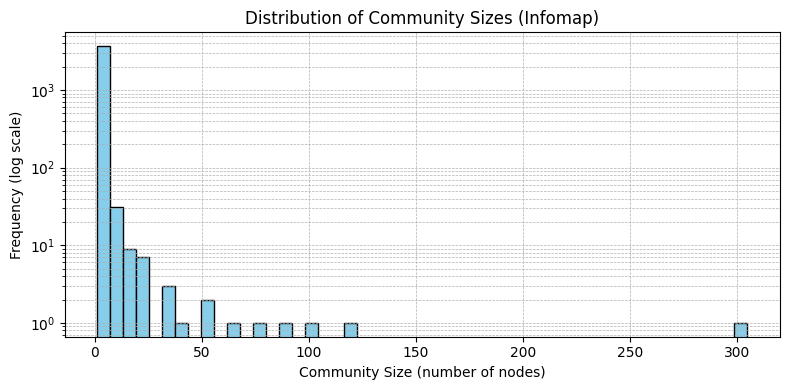

In [24]:
community_sizes = infomap_df['community_label'].value_counts()

plt.figure(figsize=(8, 4))
plt.hist(community_sizes, bins=50, color='skyblue', edgecolor='black', log=True)

plt.xlabel("Community Size (number of nodes)")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Community Sizes (Infomap)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [25]:


# let's see the community ids and sizes of the top 10 communities
print(infomap_df.value_counts('community_label').sort_values(ascending=False).head(10))



community_label
22     305
80     117
17     103
59      90
31      76
10      63
8       54
45      53
131     41
43      36
Name: count, dtype: int64


In [26]:
with model.query() as select:
    e = weighted_directed_graph.Edge()
    n1 = e.from_
    n2 = e.to
    community1 = weighted_directed_graph.compute.infomap(n1)
    community2 = weighted_directed_graph.compute.infomap(n2)
    community1 == community2
    largest_infomap_community = select( alias(n1, 's'),   alias(n2, 't'), alias(e.weight, 'weight'), alias(community1,'community_label'))

induced_community_subgraphs = largest_infomap_community.results
induced_community_subgraphs.head(5)

def visualize_community(df, community_id,message=""):
    """
    Visualizes a directed graph of a specific community in the given DataFrame.

    Parameters:
    - df: pandas DataFrame with columns ['s', 't', 'community_label']
    - community_id: int or str, the ID of the community to visualize
    """
    # Filter for the requested community
    community_df = df[df['community_label'] == community_id]

    if community_df.empty:
        print(f"Community ID {community_id} not found in the DataFrame.")
        return

    # Create the directed graph
    DG = nx.DiGraph()
    for _, row in community_df.iterrows():
        DG.add_edge(row['s'], row['t'])

    # Visualize
    plt.figure(figsize=(6, 4))
    pos = nx.spring_layout(DG, seed=42)

    nx.draw_networkx_nodes(DG, pos, node_size=100, node_color='skyblue')
    nx.draw_networkx_edges(DG, pos, arrowstyle='->', arrowsize=10, edge_color='gray')
    # nx.draw_networkx_labels(DG, pos, font_size=6)  # Optional

    plt.title(f"Visualization of Infomap Community {community_id}"+message)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


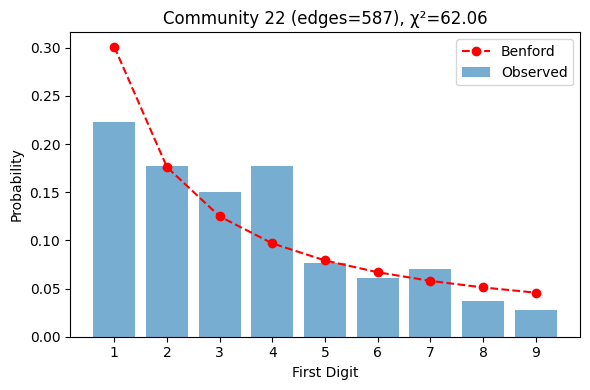

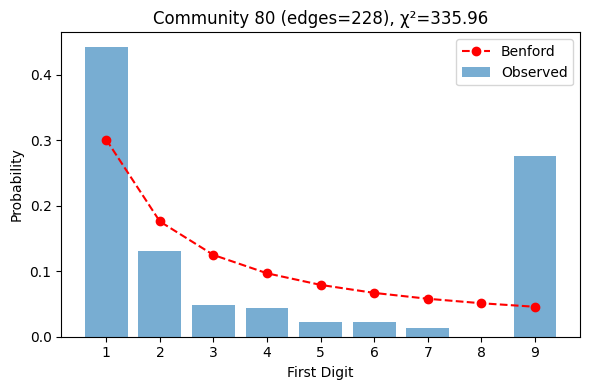

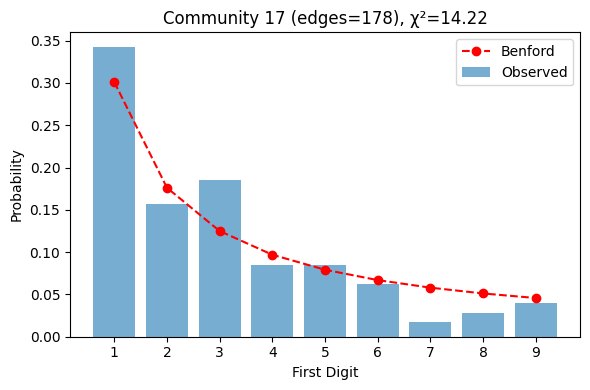

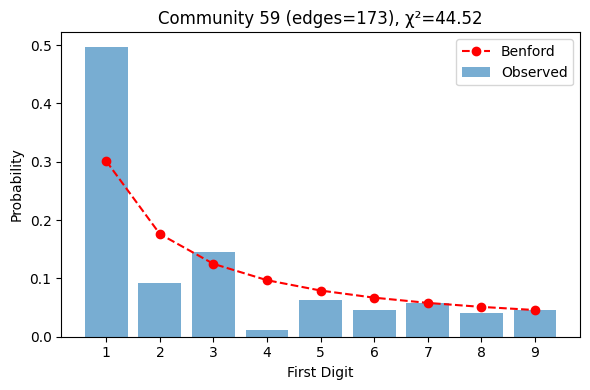

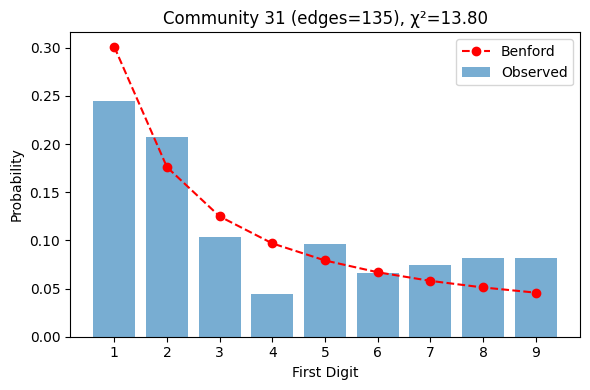

Community with highest chi-squared score: 80 (χ²=335.96)


In [27]:

# Ensure weight column is numeric
induced_community_subgraphs['weight'] = pd.to_numeric(induced_community_subgraphs['weight'], errors='coerce')

# Group by community and compute edge counts
grouped = induced_community_subgraphs.groupby('community_label')
community_sizes = grouped.size().sort_values(ascending=False)

# Select top 5 communities by edge count
top_communities = community_sizes.head(5).index

chi_scores = {}

# Analyze and plot each top community
for label in top_communities:
    group = grouped.get_group(label)
    weights = group['weight'].dropna()
    first_digits = weights.apply(first_digit).dropna().astype(int)

    digit_counts = first_digits.value_counts().reindex(range(1, 10), fill_value=0)
    total = digit_counts.sum()
    if total == 0:
        continue

    digit_probs = digit_counts / total
    expected_counts = benford_probs * total
    observed_counts = digit_counts.values

    # Manual chi-squared statistic
    chi_stat = chi_squared(observed_counts, expected_counts)
    chi_scores[label] = chi_stat

    # Plot observed vs Benford
    plt.figure(figsize=(6, 4))
    plt.bar(range(1, 10), digit_probs, alpha=0.6, label='Observed')
    plt.plot(range(1, 10), benford_probs, 'r--', marker='o', label='Benford')
    plt.xticks(range(1, 10))
    plt.xlabel("First Digit")
    plt.ylabel("Probability")
    plt.title(f"Community {label} (edges={len(weights)}), χ²={chi_stat:.2f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Print the community with the highest chi-squared score
if chi_scores:
    most_anomalous = max(chi_scores, key=chi_scores.get)
    print(f"Community with highest chi-squared score: {most_anomalous} (χ²={chi_scores[most_anomalous]:.2f})")
else:
    print("No valid communities for chi-squared computation.")
